In [ ]:
qimport tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
import numpy as np
from keras.applications import Xception
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import EfficientNetB0
from keras.applications import DenseNet201
from keras.applications import EfficientNetV2M
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from keras.utils import plot_model
import albumentations as A
from albumentations.augmentations.geometric import rotate

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d jakeshbohaju/brain-tumor

Dataset URL: https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor
License(s): CC-BY-NC-SA-4.0
 93% 13.0M/14.0M [00:01<00:00, 14.8MB/s]
100% 14.0M/14.0M [00:01<00:00, 8.57MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/brain-tumor.zip' mode='r'>>

In [ ]:
df=pd.read_csv("Brain Tumor.csv")
df.head()
df_removed=pd.DataFrame()

In [ ]:
df_removed["Image"]=df["Image"]
df_removed["Class"]=df["Class"]
df_removed.head()

Image  Class
0  Image1      0
1  Image2      0
2  Image3      1
3  Image4      1
4  Image5      0

In [ ]:
df_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   3762 non-null   object
 1   Class   3762 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.9+ KB


In [ ]:
tumor="/content/Brain Tumor/tumor"
no_tumor="/content/Brain Tumor/no_tumor"

In [ ]:

os.listdir()
path="/content/Brain Tumor/Brain Tumor"
os.makedirs(os.path.join("Brain Tumor","tumor"),exist_ok=True)
os.makedirs(os.path.join("Brain Tumor","no_tumor"),exist_ok=True)
for img in next(os.walk(path))[2]:
  # Filter the DataFrame where "Image" is "Image1"
  filtered_df = df_removed[df_removed["Image"] == img.split(".")[0]]
  # Print the "Class" values of the filtered DataFrame
  if filtered_df["Class"].values==1:
    shutil.move(os.path.join(path,img),os.path.join("Brain Tumor","tumor",img))
  else:
    shutil.move(os.path.join(path,img),os.path.join("Brain Tumor","no_tumor",img))



In [ ]:
len(os.listdir("/content/Brain Tumor/no_tumor"))

2079

In [ ]:
len(os.listdir("/content/Brain Tumor/tumor"))

1683

In [ ]:
train_tumor_dir = "Brain Tumor/train/tumor"
test_tumor_dir = "Brain Tumor/test/tumor"
train_no_tumor_dir = "Brain Tumor/train/no tumor"
test_no_tumor_dir = "Brain Tumor/test/no tumor"

In [ ]:
os.makedirs(train_tumor_dir, exist_ok=True)
os.makedirs(test_tumor_dir, exist_ok=True)
os.makedirs(train_no_tumor_dir, exist_ok=True)
os.makedirs(test_no_tumor_dir, exist_ok=True)

In [ ]:
# Collect image paths
tumor_images = [os.path.join(tumor, img) for img in os.listdir(tumor)]
no_tumor_images = [os.path.join(no_tumor, img) for img in os.listdir(no_tumor)]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split data
tumor_train, tumor_test = train_test_split(tumor_images, test_size=0.2, random_state=42)
no_tumor_train, no_tumor_test = train_test_split(no_tumor_images, test_size=0.2, random_state=42)

In [ ]:
def move_images(image_paths, dest_dir):
    for img_path in image_paths:
        shutil.move(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

# Move tumor images
move_images(tumor_train, train_tumor_dir)
move_images(tumor_test, test_tumor_dir)

# Move no tumor images
move_images(no_tumor_train, train_no_tumor_dir)
move_images(no_tumor_test, test_no_tumor_dir)

In [ ]:
import cv2
import os
import numpy as np

# Base paths to your dataset
base_path = '/content/Brain Tumor'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Paths to save processed images
output_train_path = os.path.join(base_path, 'processed_train')
output_test_path = os.path.join(base_path, 'processed_test')

# Create directories for saving processed images
os.makedirs(output_train_path, exist_ok=True)
os.makedirs(output_test_path, exist_ok=True)

# Parameters for morphological operations
kernel_size = (3, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

# Define preprocessing functions
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def apply_morph_gradient(image, kernel_size=(3,3)):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return gradient

def power_law_transformation(image, gamma=1.0, c=1):
    """
    Applies power-law (gamma) transformation to an image.

    Parameters:
    - image: The input grayscale image (2D array) or color image (3D array).
    - gamma: The gamma value for the transformation. Values >1 will darken, <1 will lighten.
    - c: The constant multiplier (default is 1).

    Returns:
    - transformed_image: The gamma-corrected image.
    """
    # Normalize the image to the range [0, 1]
    normalized_image = image / 255.0

    # Apply the power-law transformation
    transformed_image = c * np.power(normalized_image, gamma)

    # Scale back to [0, 255] and convert to an unsigned 8-bit integer type
    transformed_image = np.clip(transformed_image * 255, 0, 255).astype(np.uint8)

    return transformed_image

def crop_black_background(image, threshold=10):
    """
    Crops out black background from an image.

    Parameters:
    - image: Input grayscale or color image (numpy array).
    - threshold: Intensity threshold for detecting black background (default is 10).

    Returns:
    - cropped_image: Image cropped to remove black background.
    """
    # Convert the image to grayscale if it's not already
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a binary mask where non-black pixels are white
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Find the coordinates of non-zero (white) pixels in the binary mask
    coords = cv2.findNonZero(binary)  # Returns an array of (x, y) coordinates

    # If there are no non-black pixels, return the original image
    if coords is None:
        return image

    # Get the bounding rectangle of the non-black pixels
    x, y, w, h = cv2.boundingRect(coords)

    # Crop the image to this bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

def process_image(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = crop_black_background(img)

    # Step 1: Gaussian Blur
    #blurred_img = cv2.GaussianBlur(img, (5, 5), 0)


    #clahe_img = apply_clahe(blurred_img)

    # Step 2: High-pass filter
    #high_pass = img - blurred_img
    #high_pass_img = cv2.addWeighted(img, 1.5, high_pass, -0.5, 0)

    # Step 3: Erosion
    #eroded_img = cv2.erode(clahe_img, kernel, iterations=1)

    # Step 4: Dilation
    #dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    gamma_value = 2.8  # Change this value to experiment
    transformed_image = power_law_transformation(cropped_image, gamma=gamma_value)

    # Save the processed image
    processed_filename = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(processed_filename, transformed_image)

def process_dataset(dataset_path, output_path):
    categories = ['tumor', 'no tumor']
    for category in categories:
        # Create category directories in the output path
        category_input_path = os.path.join(dataset_path, category)
        category_output_path = os.path.join(output_path, category)
        os.makedirs(category_output_path, exist_ok=True)

        # Process each image in the category folder
        for image_file in os.listdir(category_input_path):
            image_path = os.path.join(category_input_path, image_file)
            process_image(image_path, category_output_path)

# Process train and test datasets
process_dataset(train_path, output_train_path)
process_dataset(test_path, output_test_path)

In [ ]:
base_path = '/content/Brain Tumor'
train_path = os.path.join(base_path, 'processed_train')

# Paths to save processed (augmented) images
output_train_path = os.path.join(base_path, 'augmented_train')
os.makedirs(output_train_path, exist_ok=True)

# Define augmentation transformations
transform = A.Compose([
    A.RandomRotate90(p=1),                     # Randomly rotate by 90, 180, or 270 degrees
    A.Flip(p=0.5),                          # Random horizontal or vertical flip
    A.Transpose(p=0.5)                     # Random transposition

])

def augment_and_save(image, output_folder, base_filename, num_augmentations=4):
    for i in range(num_augmentations):
        augmented = transform(image=image)
        augmented_image = augmented["image"]

        # Save augmented image with unique name
        augmented_filename = f"{base_filename}_aug_{i}.jpg"
        cv2.imwrite(os.path.join(output_folder, augmented_filename), augmented_image)

def augmented_dataset(dataset_path, output_path, augment=True, num_augmentations=4):

    categories = ['tumor', 'no tumor']
    for category in categories:
        # Create category directories in the output path
        category_input_path = os.path.join(dataset_path, category)
        category_output_path = os.path.join(output_path, category)
        os.makedirs(category_output_path, exist_ok=True)

        # Process each image in the category folder
        for image_file in os.listdir(category_input_path):
            image_path = os.path.join(category_input_path, image_file)
            image = cv2.imread(image_path)

            # Save the original image in the output folder
            cv2.imwrite(os.path.join(category_output_path, image_file), image)

            # Apply augmentations if required
            if augment:
                augment_and_save(image, category_output_path, os.path.splitext(image_file)[0], num_augmentations)

# Process train dataset with augmentation
augmented_dataset(train_path, output_train_path, augment=True, num_augmentations=4)

<ipython-input-19-483e1c7f11d3>:11: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),                          # Random horizontal or vertical flip


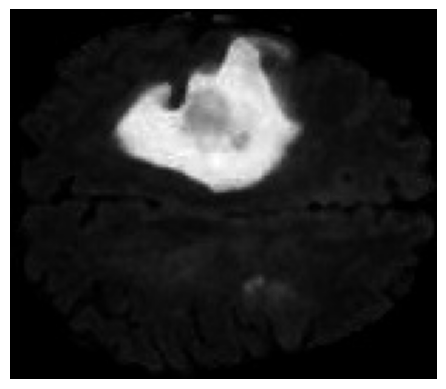

Image3077_aug_0.jpg


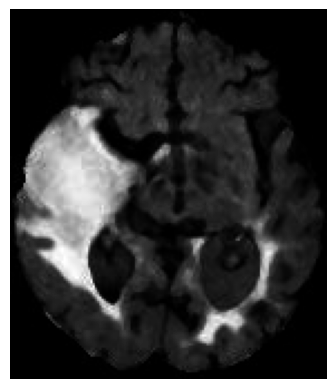

Image1774_aug_1.jpg


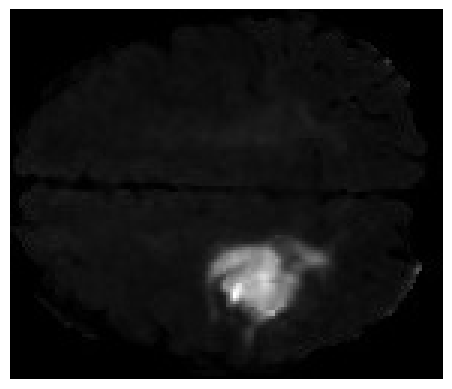

Image1531_aug_1.jpg


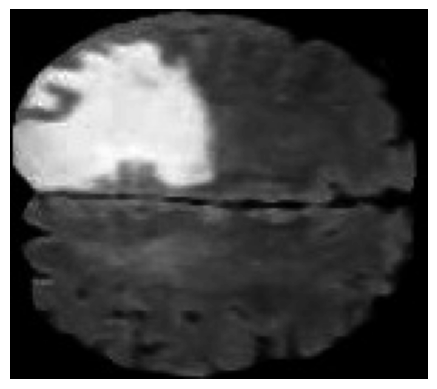

Image1550_aug_1.jpg


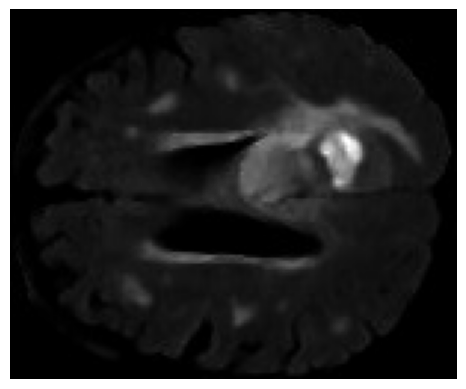

Image3481_aug_2.jpg


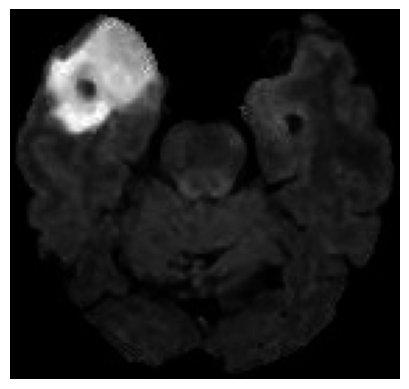

Image2948.jpg


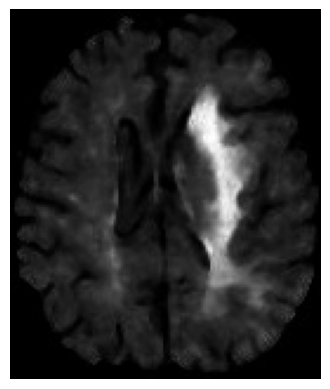

Image2298.jpg


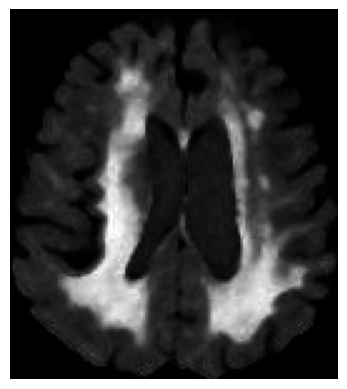

Image3133.jpg


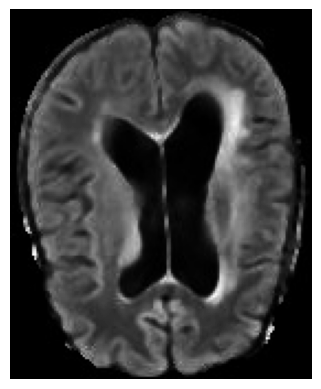

Image2631_aug_0.jpg


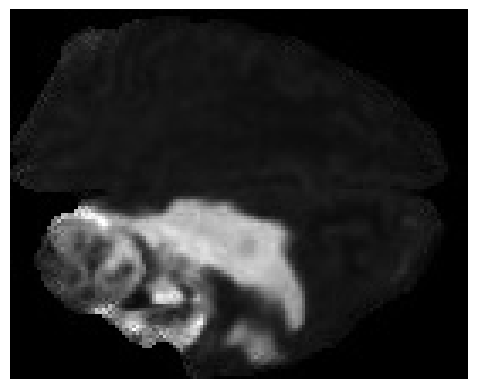

Image3342_aug_3.jpg


In [ ]:
def show_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Specify the directory containing images
path = "/content/Brain Tumor/augmented_train/tumor"

# Display the first 10 images from the folder
for i, image_file in enumerate(os.listdir(path)[:10]):  # Limit to first 10 images
    image_path = os.path.join(path, image_file)
    show_image(image_path)
    print(image_file)

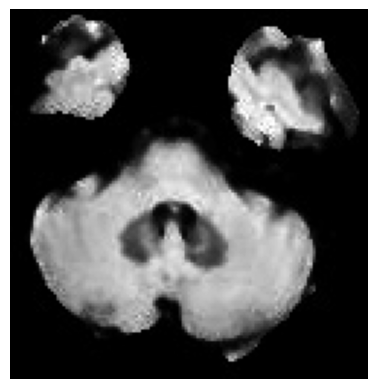

Image2757.jpg


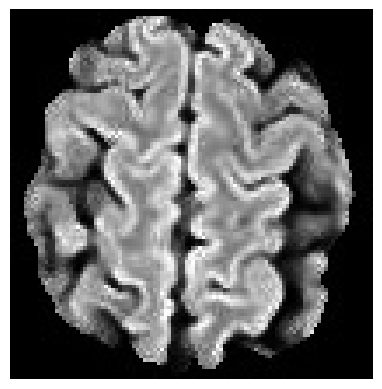

Image2339_aug_2.jpg


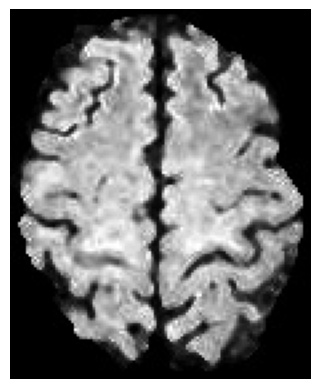

Image504_aug_1.jpg


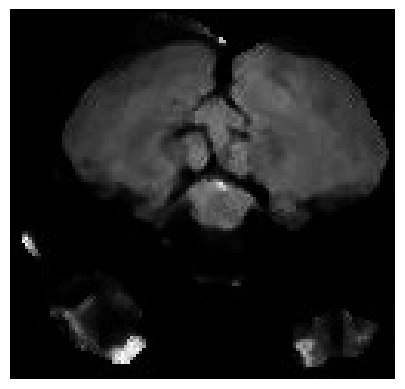

Image986_aug_1.jpg


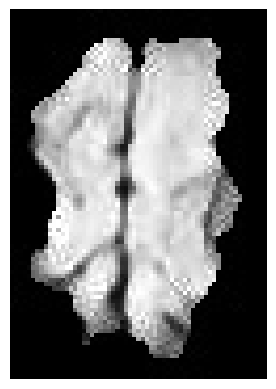

Image740_aug_1.jpg


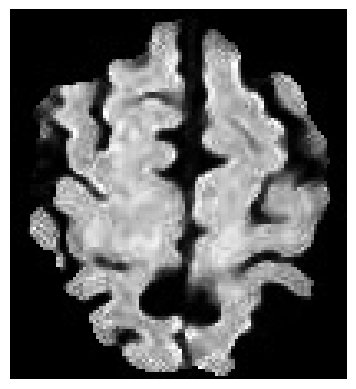

Image542.jpg


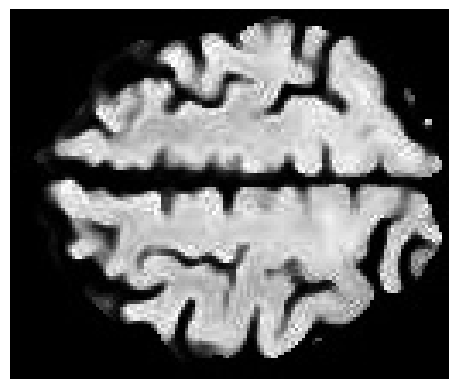

Image1017_aug_1.jpg


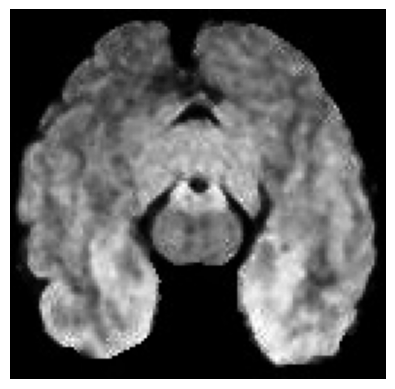

Image2856_aug_3.jpg


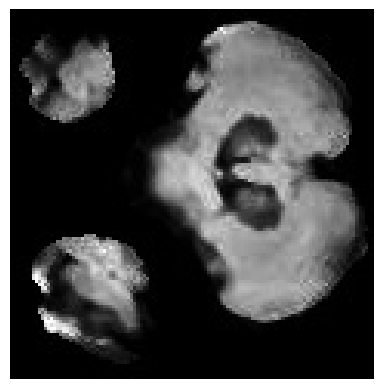

Image1425_aug_2.jpg


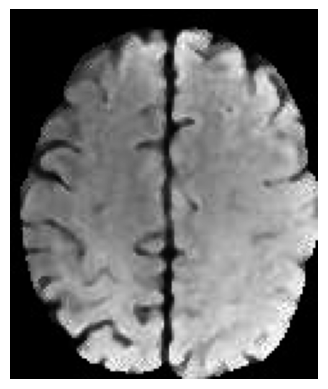

Image1330.jpg


In [ ]:
def show_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Specify the directory containing images
path = "/content/Brain Tumor/augmented_train/no tumor"

# Display the first 10 images from the folder
for i, image_file in enumerate(os.listdir(path)[:10]):  # Limit to first 10 images
    image_path = os.path.join(path, image_file)
    show_image(image_path)
    print(image_file)

In [ ]:
train_dataset=keras.utils.image_dataset_from_directory(
    directory="/content/Brain Tumor/augmented_train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224,224)
)

test_dataset=keras.utils.image_dataset_from_directory(
    directory="/content/Brain Tumor/processed_test",
    labels="inferred",
    label_mode="int",
    shuffle=False,
    batch_size=32,
    image_size=(224,224)
)

Found 15045 files belonging to 2 classes.
Found 753 files belonging to 2 classes.


In [ ]:
print(len(os.listdir("/content/Brain Tumor/augmented_train/no tumor")))
print(len(os.listdir("/content/Brain Tumor/augmented_train/tumor")))
print(len(os.listdir("/content/Brain Tumor/processed_test/no tumor")))
print(len(os.listdir("/content/Brain Tumor/processed_test/tumor")))

8315
6730
416
337


Model 1: **EfficientNEtB0**

In [ ]:
conv_base1= EfficientNetB0(weights='imagenet',
                     include_top=False,
                     input_shape=(224,224,3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
conv_base1.trainable=True
set_trainable=False
for layer in conv_base1.layers:
  if layer.name=="top_conv":
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False



In [ ]:
conv_base1.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 412,160 (1.57 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
input_tensor = tf.keras.Input(shape=IMG_SHAPE)
_ = conv_base1(input_tensor)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.413432 to fit



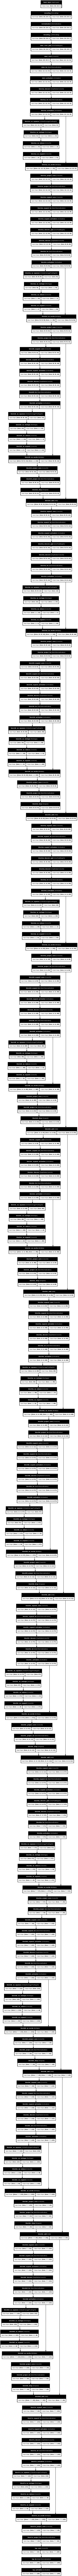

In [ ]:
from keras.utils import plot_model
plot_model(conv_base1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model1 = Sequential([
    conv_base1,
    GlobalAveragePooling2D(),  # Add this layer before Flatten
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
tf.random.set_seed(42)
model1.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 576,257 (2.20 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

In [ ]:
model1.build()

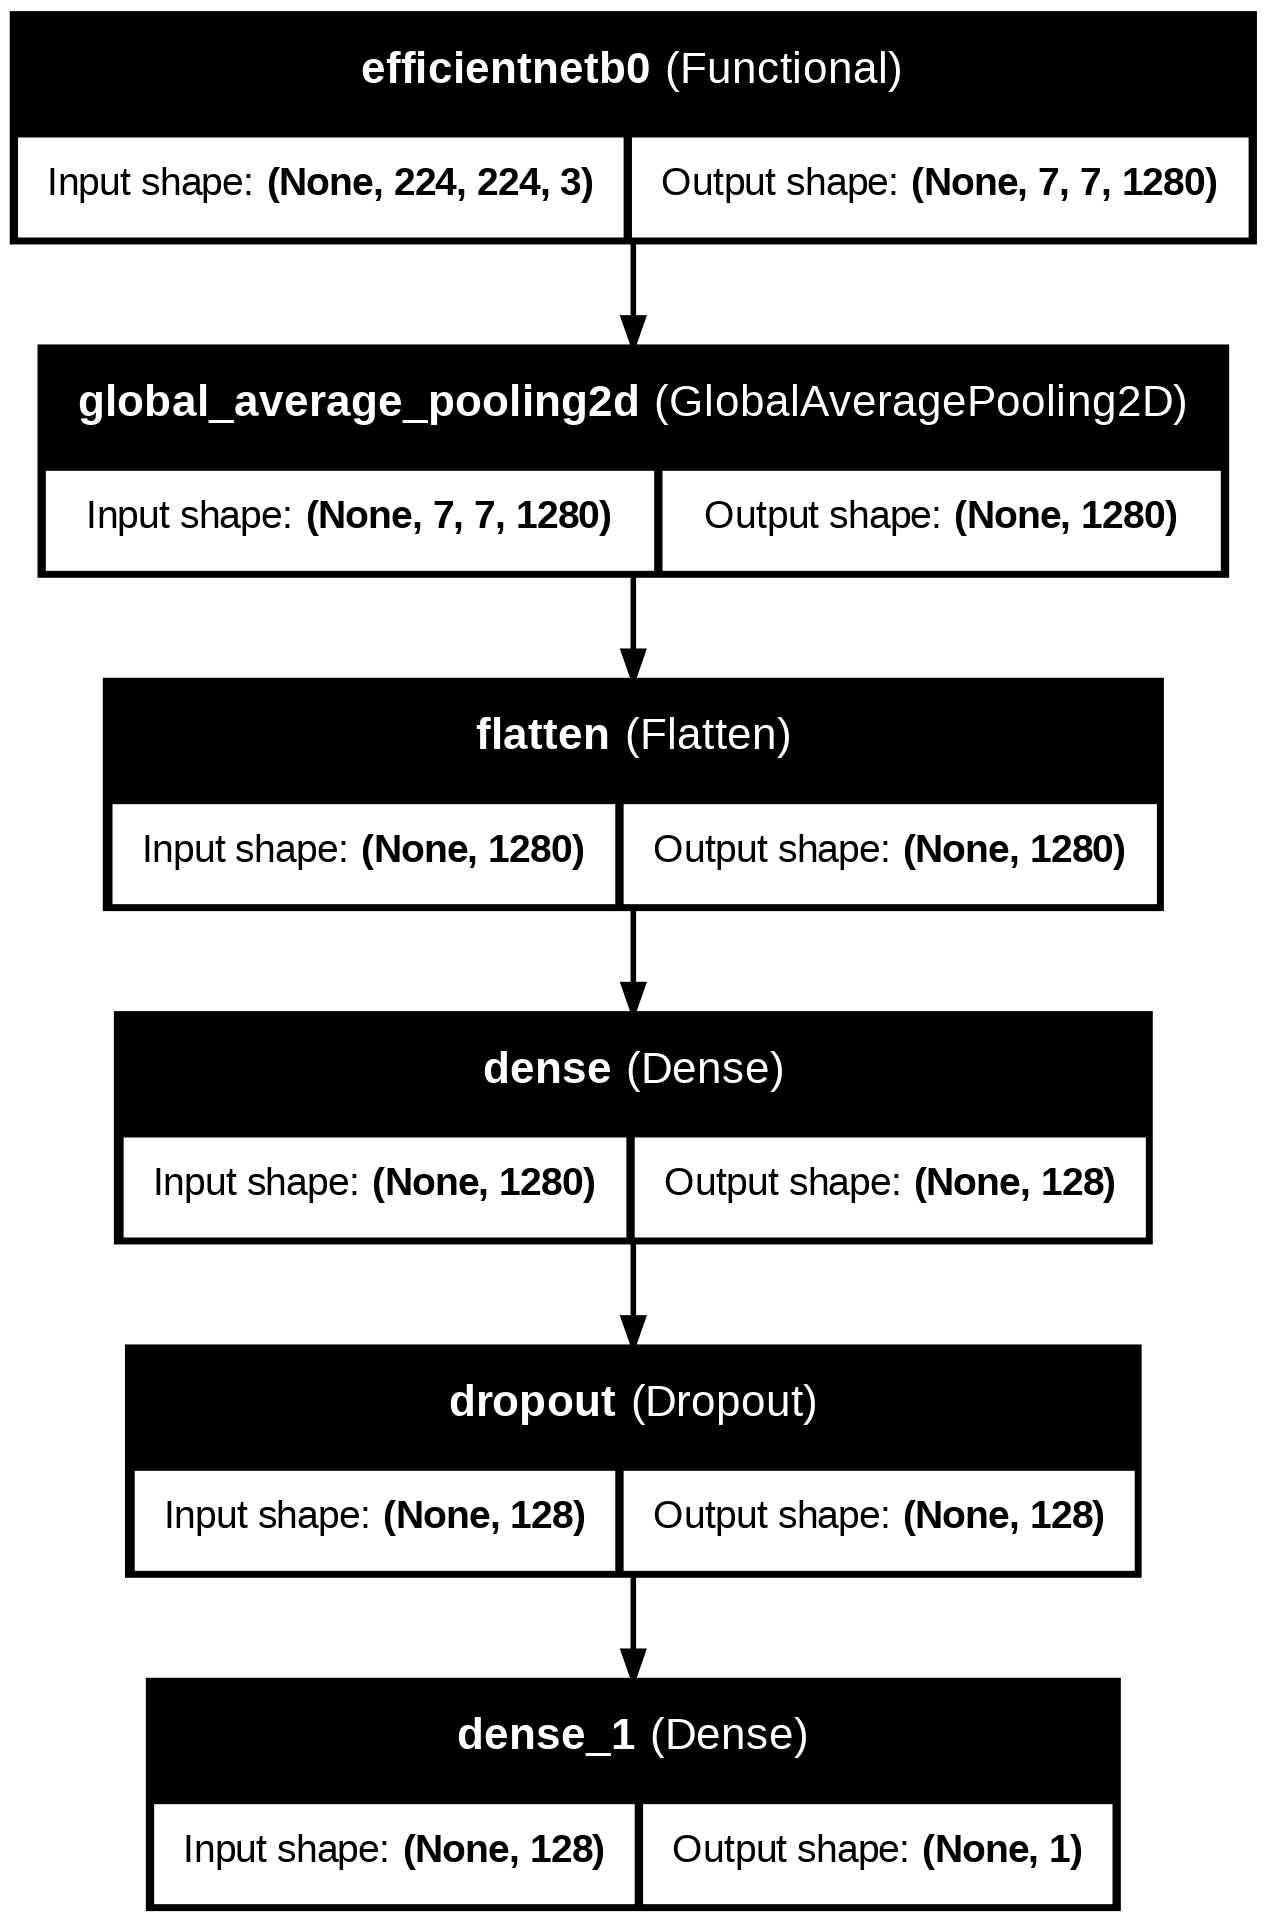

In [ ]:
plot_model(model1, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model1.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

# Train your model with the callback
history1 = model1.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - accuracy: 0.8839 - loss: 0.2945 - val_accuracy: 0.9469 - val_loss: 0.1264
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9612 - loss: 0.1086 - val_accuracy: 0.9602 - val_loss: 0.0929
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9733 - loss: 0.0766 - val_accuracy: 0.9615 - val_loss: 0.0962
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9820 - loss: 0.0556 - val_accuracy: 0.9734 - val_loss: 0.0720
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9881 - loss: 0.0415 - val_accuracy: 0.9814 - val_loss: 0.0669
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9896 - loss: 0.0344 - val_accuracy: 0.9774 - val_loss: 0.0705
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9908 - loss: 0.0285 - val_accuracy: 0.9841 - val_loss: 0.0740
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9940 - loss: 0.0208 -

In [ ]:
loaded_model1 = tf.keras.models.load_model('best_model1.keras')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the threshold value, e.g., 0.5
threshold = 0.5

# Get predictions on the test set
y_pred_prob = loaded_model1.predict(test_dataset)  # Probabilities

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step
Model Performance on Test Set:
Accuracy: 0.8884
Precision: 1.0000
Recall: 0.7507
F1 Score: 0.8576


In [ ]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_true, y_pred)
cm1

array([[416,   0],
       [ 84, 253]])

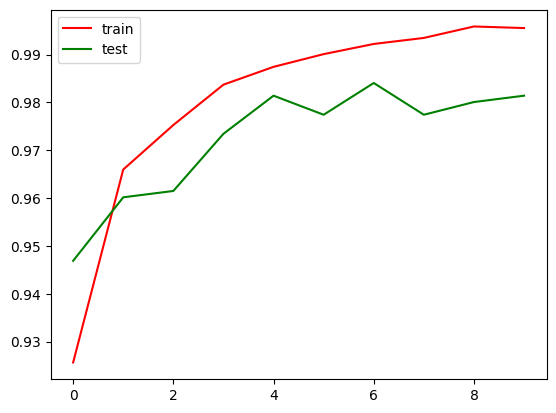

In [ ]:
plt.plot(history1.history["accuracy"],label="train",color="red")
plt.plot(history1.history["val_accuracy"],label="test", color="green")
plt.legend()
plt.show()

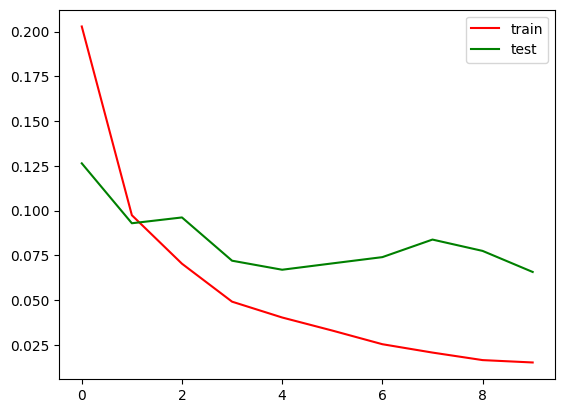

In [ ]:
plt.plot(history1.history["loss"],label="train",color="red")
plt.plot(history1.history["val_loss"],label="test", color="green")
plt.legend()
plt.show()

Model 2: **DenseNet201**

In [ ]:
conv_base2= DenseNet201(weights='imagenet',
                     include_top=False,
                     input_shape=(224,224,3)
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:

conv_base2.trainable=True
set_trainable=False
for layer in conv_base2.layers:
  if layer.name=="conv5_block32_1_conv":
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False



In [ ]:
conv_base2.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 282,624 (1.08 MB)

 Non-trainable params: 18,039,360 (68.81 MB)

In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
input_tensor = tf.keras.Input(shape=IMG_SHAPE)
_ = conv_base2(input_tensor)

In [ ]:
model2 = Sequential([
    conv_base2,
    GlobalAveragePooling2D(),  # Add this layer before Flatten
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
tf.random.set_seed(42)
model2.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         245,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,568,001 (70.83 MB)

 Trainable params: 528,641 (2.02 MB)

 Non-trainable params: 18,039,360 (68.81 MB)

In [ ]:
model2.build()

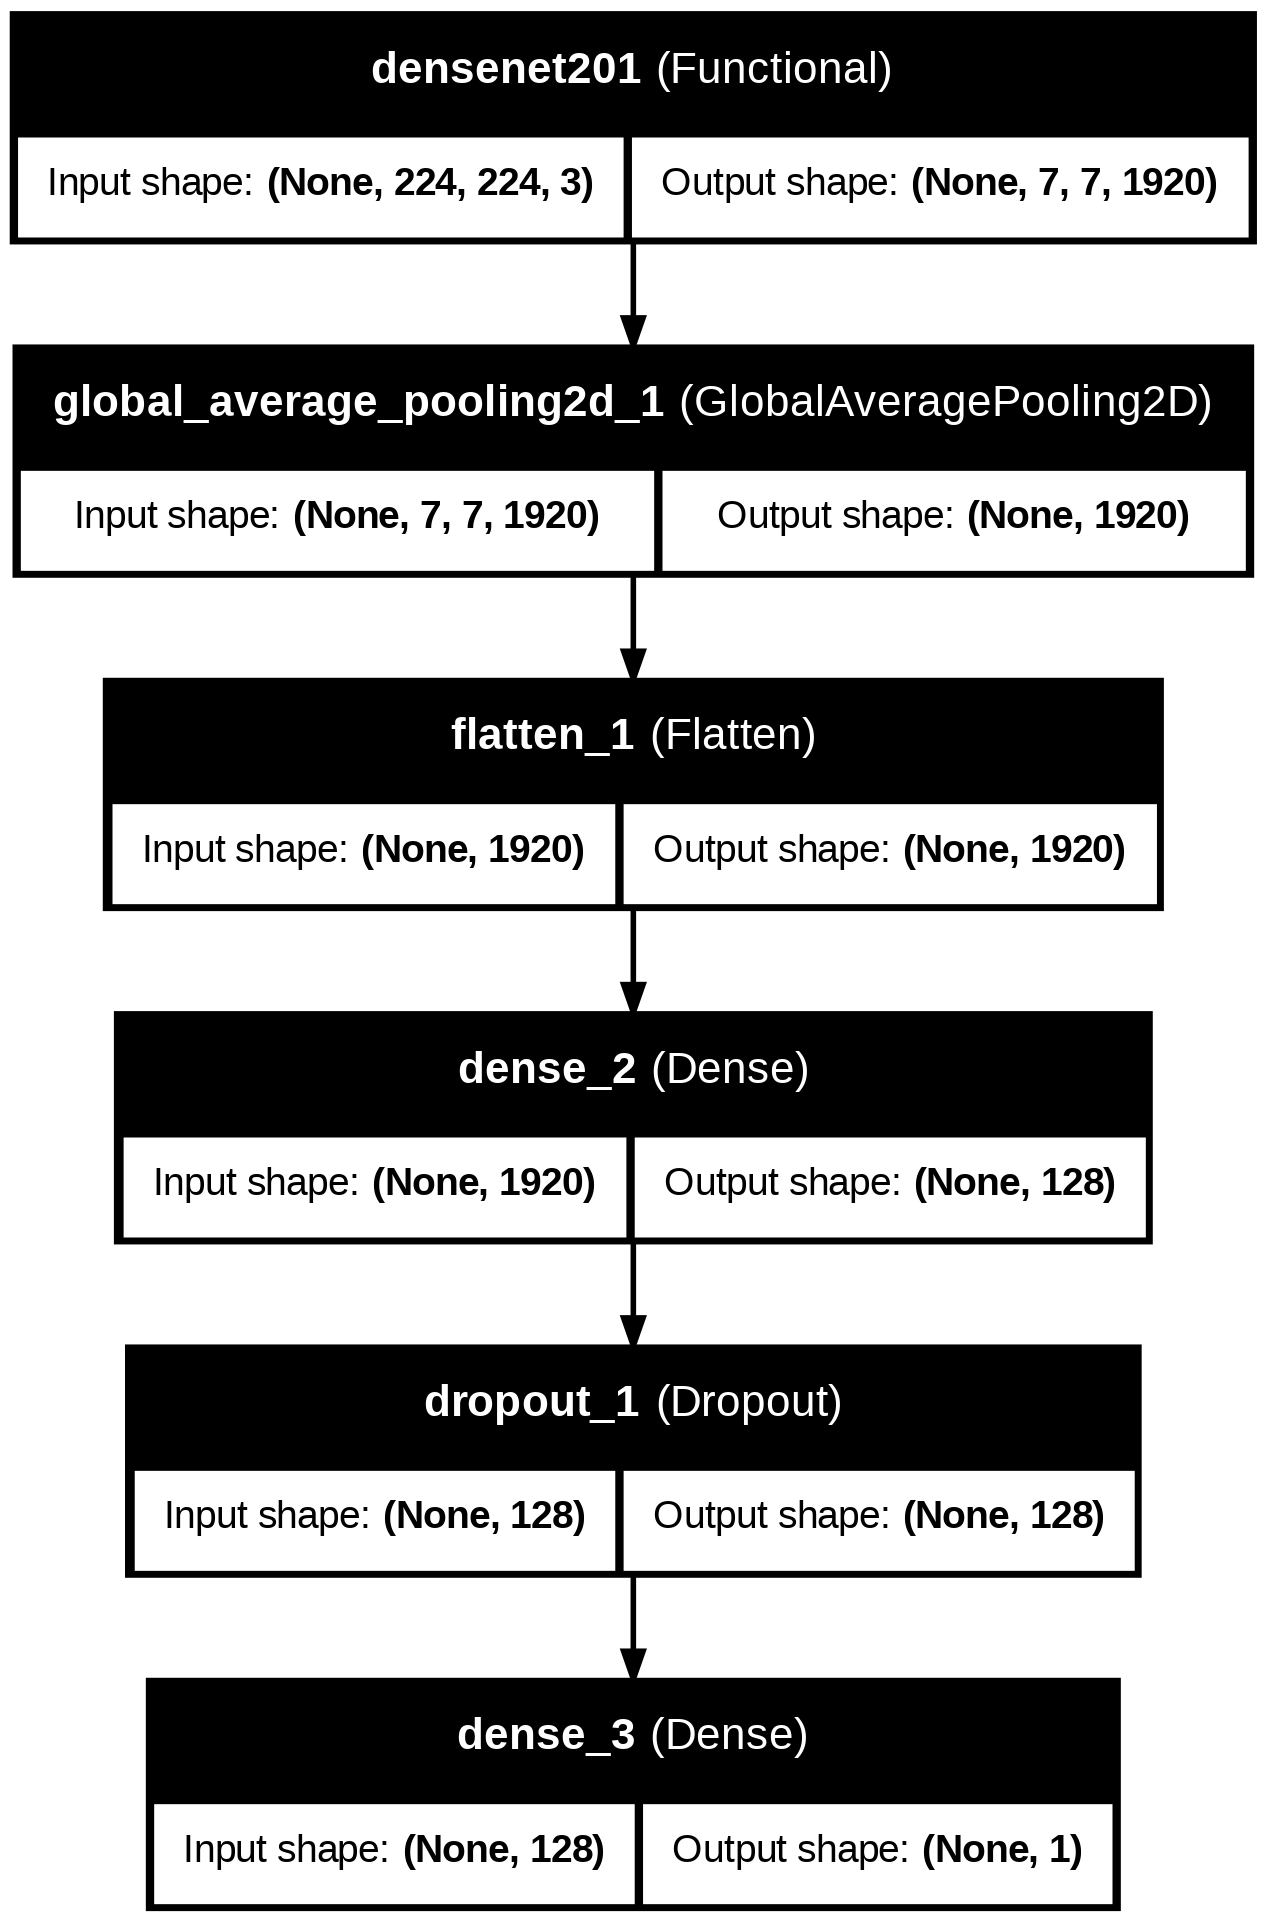

In [ ]:
plot_model(model2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model2.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

# Train your model with the callback
history2 = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 170s 262ms/step - accuracy: 0.8388 - loss: 0.3434 - val_accuracy: 0.9469 - val_loss: 0.1308
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 114s 131ms/step - accuracy: 0.9633 - loss: 0.1049 - val_accuracy: 0.9695 - val_loss: 0.1109
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.9734 - loss: 0.0714 - val_accuracy: 0.9562 - val_loss: 0.1032
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - accuracy: 0.9866 - loss: 0.0397 - val_accuracy: 0.9748 - val_loss: 0.0875
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.9886 - loss: 0.0332 - val_accuracy: 0.9721 - val_loss: 0.0968
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.9936 - loss: 0.0190 - val_accuracy: 0.9734 - val_loss: 0.0912
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.9915 - loss: 0.0245 - val_accuracy: 0.9655 - val_loss: 0.1265
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9946 - loss:

In [ ]:
loaded_model2 = tf.keras.models.load_model('best_model2.keras')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the threshold value, e.g., 0.5
threshold = 0.5

# Get predictions on the test set
y_pred_prob = loaded_model2.predict(test_dataset)  # Probabilities

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 711ms/step
Model Performance on Test Set:
Accuracy: 0.9774
Precision: 0.9819
Recall: 0.9674
F1 Score: 0.9746


In [ ]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_true, y_pred)
cm2

array([[410,   6],
       [ 11, 326]])

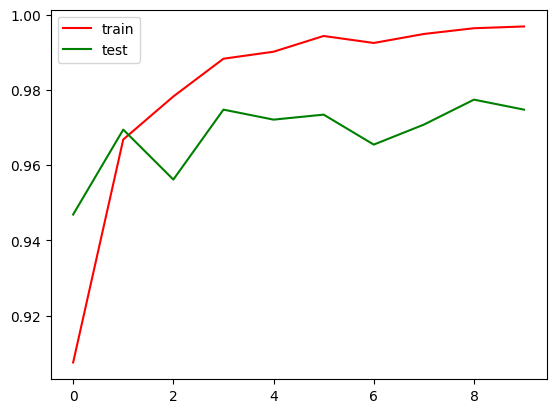

In [ ]:
plt.plot(history2.history["accuracy"],label="train",color="red")
plt.plot(history2.history["val_accuracy"],label="test", color="green")
plt.legend()
plt.show()

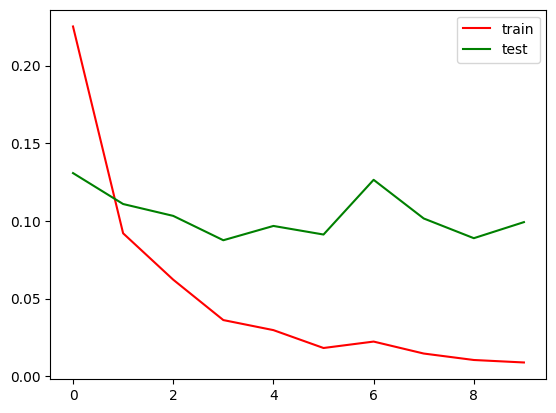

In [ ]:
plt.plot(history2.history["loss"],label="train",color="red")
plt.plot(history2.history["val_loss"],label="test", color="green")
plt.legend()
plt.show()

Model 3: **IncenptionV3**

In [ ]:
conv_base3= InceptionV3(weights='imagenet',
                     include_top=False,
                     input_shape=(224,224,3)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:

conv_base3.trainable=True
set_trainable=False
for layer in conv_base3.layers:
  if layer.name=="conv2d_93":
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False



In [ ]:
conv_base3.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 393,728 (1.50 MB)

 Non-trainable params: 21,409,056 (81.67 MB)

In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
input_tensor = tf.keras.Input(shape=IMG_SHAPE)
_ = conv_base3(input_tensor)

In [ ]:
model3 = Sequential([
    conv_base3,
    GlobalAveragePooling2D(),  # Add this layer before Flatten
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
tf.random.set_seed(42)
model3.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 656,129 (2.50 MB)

 Non-trainable params: 21,409,056 (81.67 MB)

In [ ]:
model3.build()

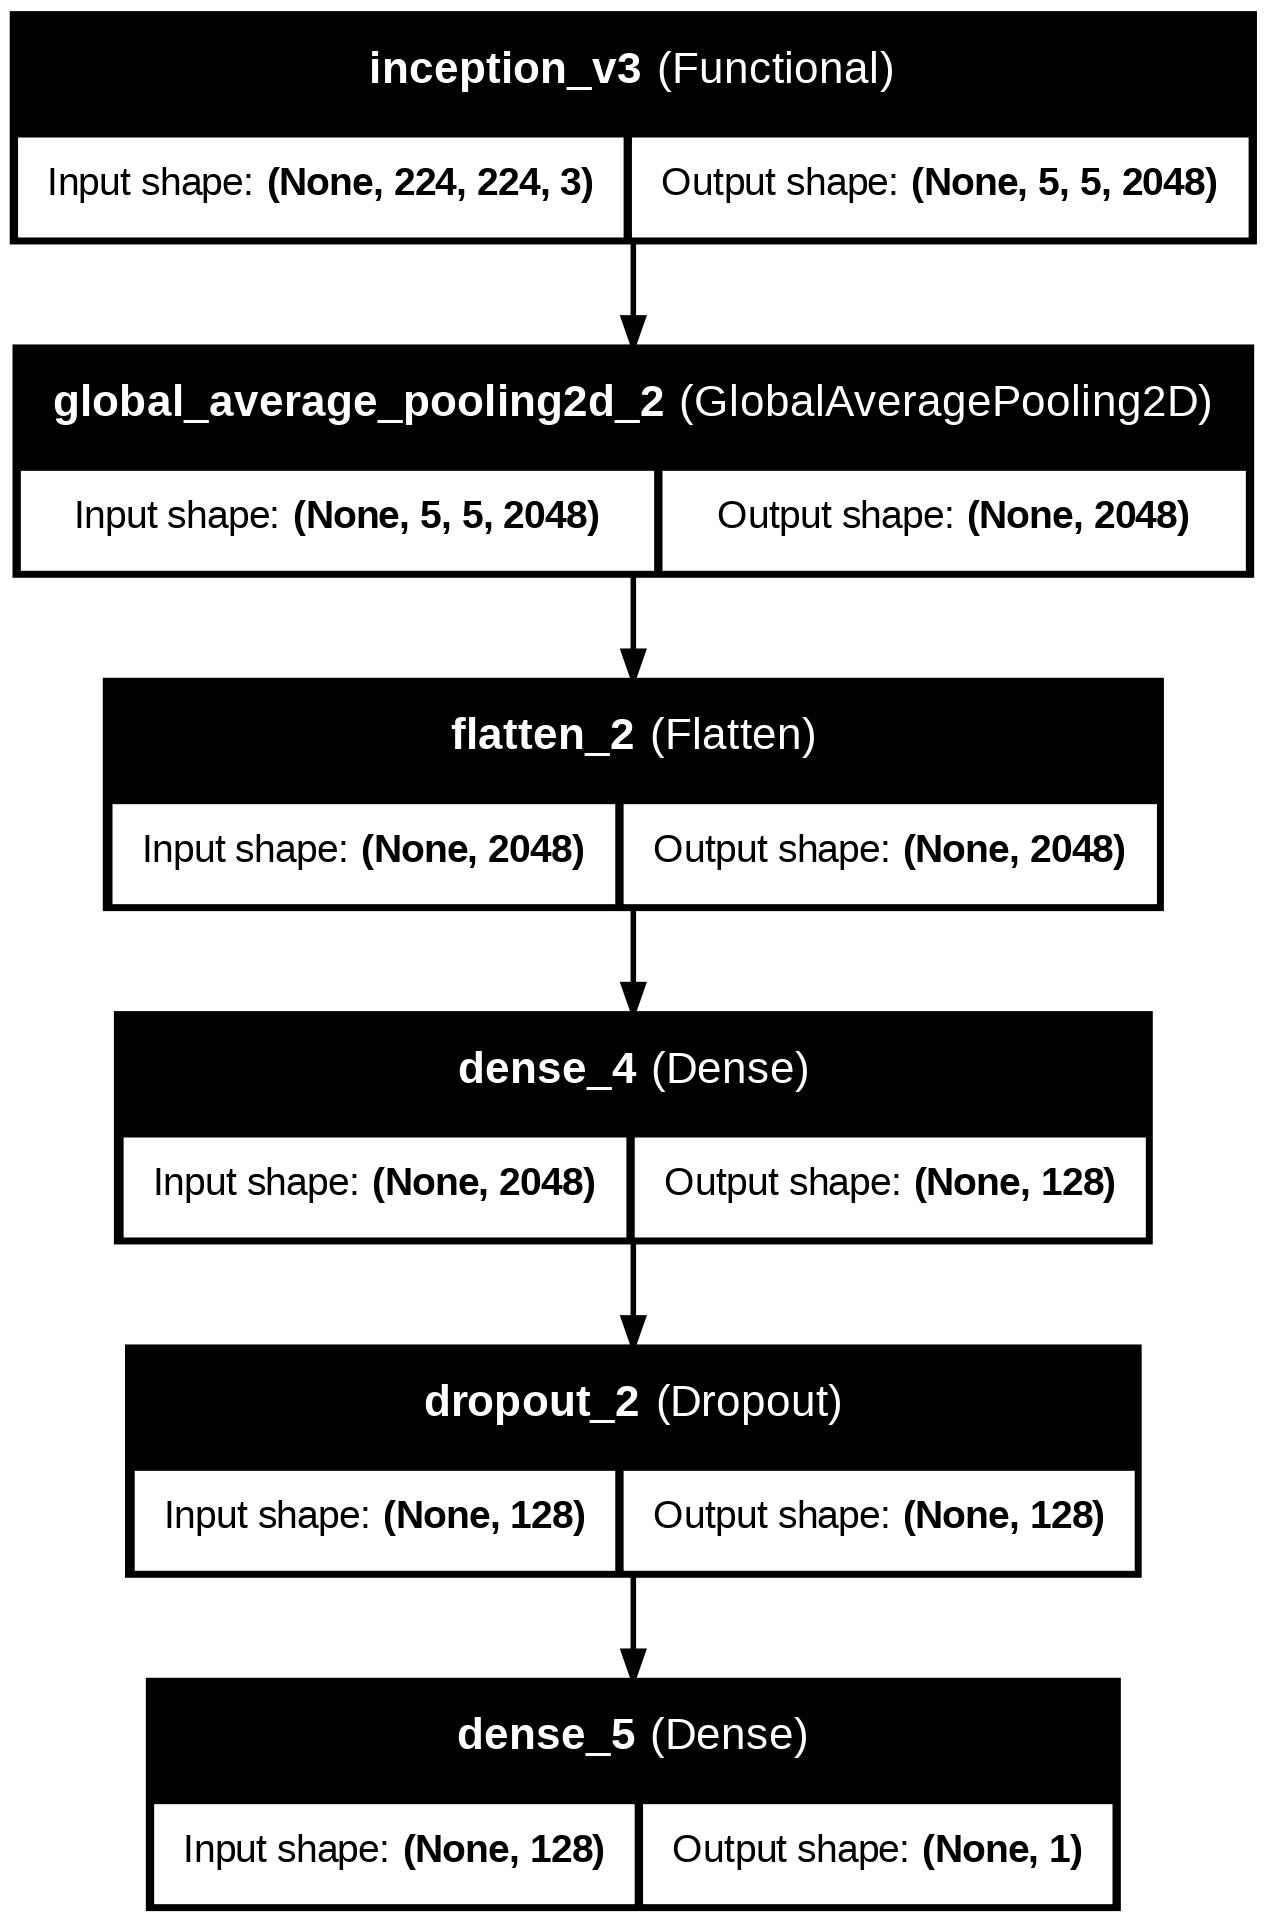

In [ ]:
plot_model(model3, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model3.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

# Train your model with the callback
history3 = model3.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 76s 126ms/step - accuracy: 0.7877 - loss: 0.8841 - val_accuracy: 0.9124 - val_loss: 0.2101
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.9107 - loss: 0.2385 - val_accuracy: 0.9309 - val_loss: 0.1724
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.9349 - loss: 0.1763 - val_accuracy: 0.9349 - val_loss: 0.1751
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.9442 - loss: 0.1458 - val_accuracy: 0.9402 - val_loss: 0.1498
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9585 - loss: 0.1204 - val_accuracy: 0.9469 - val_loss: 0.1344
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9608 - loss: 0.1041 - val_accuracy: 0.9522 - val_loss: 0.1373
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9619 - loss: 0.1079 - val_accuracy: 0.9429 - val_loss: 0.1355
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9710 - loss: 0.0784 -

In [ ]:
loaded_model3 = tf.keras.models.load_model('best_model3.keras')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the threshold value, e.g., 0.5
threshold = 0.5

# Get predictions on the test set
y_pred_prob = loaded_model3.predict(test_dataset)  # Probabilities

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step
Model Performance on Test Set:
Accuracy: 0.9602
Precision: 0.9582
Recall: 0.9525
F1 Score: 0.9554


In [ ]:
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_true, y_pred)
cm3

array([[402,  14],
       [ 16, 321]])

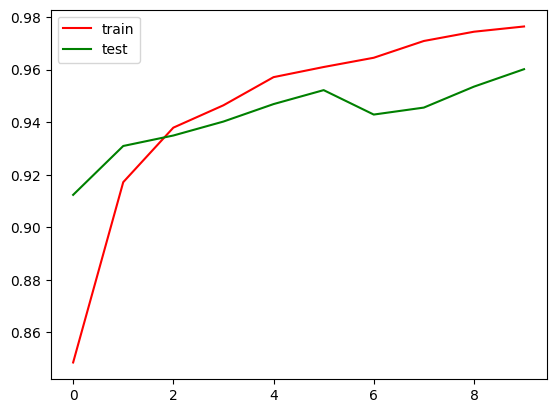

In [ ]:
plt.plot(history3.history["accuracy"],label="train",color="red")
plt.plot(history3.history["val_accuracy"],label="test", color="green")
plt.legend()
plt.show()

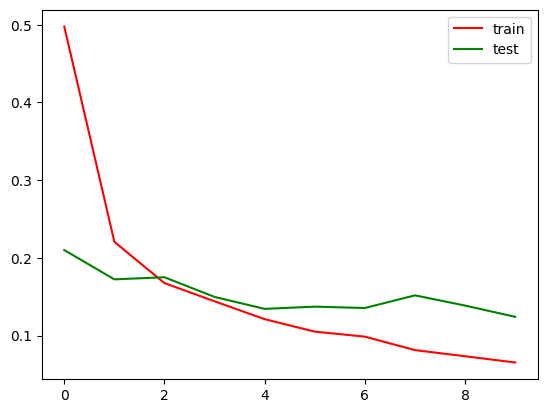

In [ ]:
plt.plot(history3.history["loss"],label="train",color="red")
plt.plot(history3.history["val_loss"],label="test", color="green")
plt.legend()
plt.show()

Model 4: **EfficientNetV2M**

In [ ]:
conv_base4 = EfficientNetV2M(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224,224,3)

)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
input_tensor = tf.keras.Input(shape=IMG_SHAPE)
_ = conv_base4(input_tensor)

In [ ]:
conv_base4.trainable=True
set_trainable=False
for layer in conv_base4.layers:
  if layer.name=="top_conv":
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False

In [ ]:
conv_base4.summary()

Model: "efficientnetv2-m"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 53,150,388 (202.75 MB)

 Trainable params: 657,920 (2.51 MB)

 Non-trainable params: 52,492,468 (200.24 MB)

In [ ]:
model4 = Sequential([
    conv_base4,
    GlobalAveragePooling2D(),  # Add this layer before Flatten
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
tf.random.set_seed(42)
model4.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)        │ (None, 7, 7, 1280)          │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,314,485 (203.38 MB)

 Trainable params: 822,017 (3.14 MB)

 Non-trainable params: 52,492,468 (200.24 MB)

In [ ]:
model4.build()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model4.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

# Train your model with the callback
history4 = model4.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 238s 340ms/step - accuracy: 0.8411 - loss: 0.3727 - val_accuracy: 0.9070 - val_loss: 0.2155
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 136s 172ms/step - accuracy: 0.9286 - loss: 0.1845 - val_accuracy: 0.9442 - val_loss: 0.1644
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9492 - loss: 0.1439 - val_accuracy: 0.9562 - val_loss: 0.1408
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 80s 166ms/step - accuracy: 0.9592 - loss: 0.1147 - val_accuracy: 0.9535 - val_loss: 0.1350
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 79s 167ms/step - accuracy: 0.9607 - loss: 0.1032 - val_accuracy: 0.9588 - val_loss: 0.1279
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 84s 172ms/step - accuracy: 0.9695 - loss: 0.0835 - val_accuracy: 0.9628 - val_loss: 0.1211
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 79s 166ms/step - accuracy: 0.9745 - loss: 0.0713 - val_accuracy: 0.9615 - val_loss: 0.1216
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 85s 172ms/step - accuracy: 0.9762 - loss:

In [ ]:
loaded_model4 = tf.keras.models.load_model('best_model4.keras')

In [ ]:
loaded_model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)        │ (None, 7, 7, 1280)          │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,958,521 (209.65 MB)

 Trainable params: 822,017 (3.14 MB)

 Non-trainable params: 52,492,468 (200.24 MB)

 Optimizer params: 1,644,036 (6.27 MB)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the threshold value, e.g., 0.5
threshold = 0.5

# Get predictions on the test set
y_pred_prob = loaded_model4.predict(test_dataset)  # Probabilities

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step
Model Performance on Test Set:
Accuracy: 0.9641
Precision: 0.9669
Recall: 0.9525
F1 Score: 0.9596


In [ ]:
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_true, y_pred)
cm4

array([[405,  11],
       [ 16, 321]])

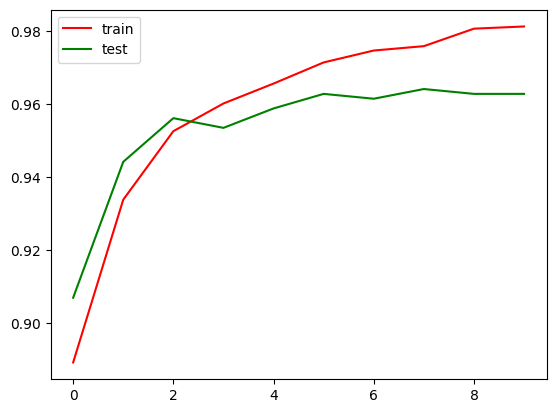

In [ ]:
plt.plot(history4.history["accuracy"],label="train",color="red")
plt.plot(history4.history["val_accuracy"],label="test", color="green")
plt.legend()
plt.show()

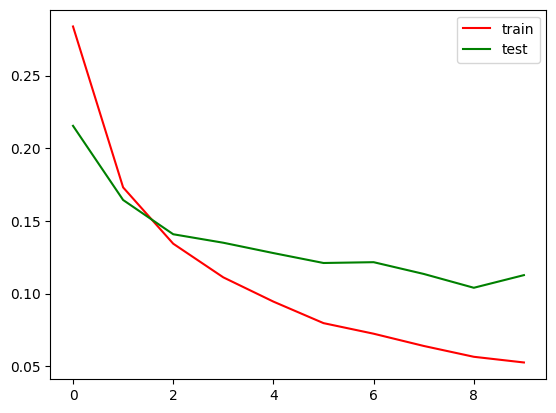

In [ ]:
plt.plot(history4.history["loss"],label="train",color="red")
plt.plot(history4.history["val_loss"],label="test", color="green")
plt.legend()
plt.show()

Model 5: **VGG16**

In [ ]:
conv_base5 = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224,224,3)

)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
IMG_SHAPE = (224, 224, 3)

In [ ]:
input_tensor = tf.keras.Input(shape=IMG_SHAPE)
_ = conv_base5(input_tensor)

In [ ]:
conv_base5.trainable=True
set_trainable=False
for layer in conv_base5.layers:
  if layer.name==" block5_conv3":
    set_trainable=True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False

In [ ]:
conv_base5.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model5 = Sequential([
    conv_base5,
    GlobalAveragePooling2D(),  # Add this layer before Flatten
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
tf.random.set_seed(42)
model5.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model5.build()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model5.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)

# Train your model with the callback
history5 = model5.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 96s 175ms/step - accuracy: 0.7292 - loss: 0.6279 - val_accuracy: 0.8991 - val_loss: 0.2777
Epoch 2/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - accuracy: 0.9031 - loss: 0.2531 - val_accuracy: 0.9163 - val_loss: 0.2259
Epoch 3/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9237 - loss: 0.2002 - val_accuracy: 0.9270 - val_loss: 0.2046
Epoch 4/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.9374 - loss: 0.1641 - val_accuracy: 0.9309 - val_loss: 0.1945
Epoch 5/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - accuracy: 0.9439 - loss: 0.1508 - val_accuracy: 0.9309 - val_loss: 0.1931
Epoch 6/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.9505 - loss: 0.1328 - val_accuracy: 0.9389 - val_loss: 0.1701
Epoch 7/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - accuracy: 0.9552 - loss: 0.1165 - val_accuracy: 0.9376 - val_loss: 0.1719
Epoch 8/10
471/471 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.9590 - loss: 

In [ ]:
loaded_model5 = tf.keras.models.load_model('best_model5.keras')

In [ ]:
loaded_model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,912,069 (56.89 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 131,588 (514.02 KB)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the threshold value, e.g., 0.5
threshold = 0.5

# Get predictions on the test set
y_pred_prob = loaded_model5.predict(test_dataset)  # Probabilities

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step
Model Performance on Test Set:
Accuracy: 0.9456
Precision: 0.9625
Recall: 0.9139
F1 Score: 0.9376


In [ ]:
from sklearn.metrics import confusion_matrix
cm5 = confusion_matrix(y_true, y_pred)
cm5

array([[404,  12],
       [ 29, 308]])

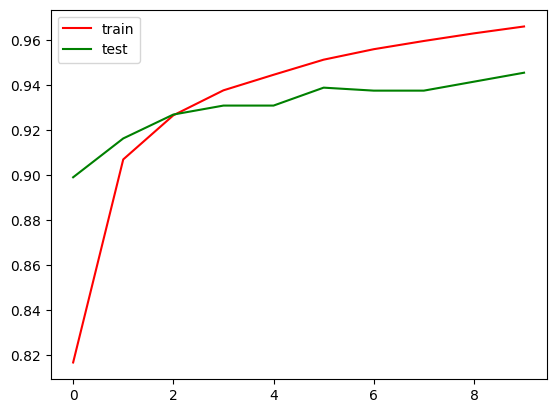

In [ ]:
plt.plot(history5.history["accuracy"],label="train",color="red")
plt.plot(history5.history["val_accuracy"],label="test", color="green")
plt.legend()
plt.show()

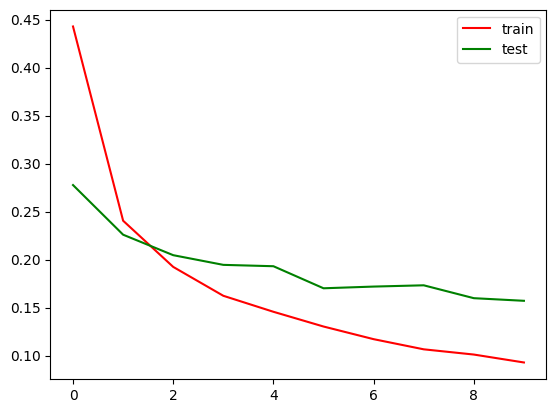

In [ ]:
plt.plot(history5.history["loss"],label="train",color="red")
plt.plot(history5.history["val_loss"],label="test", color="green")
plt.legend()
plt.show()

Evaluation performance

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# List of your trained models
models = [model1, model2, model3, model4, model5]

# Assuming `test_dataset` is the input for prediction
test_predictions = []

# Step 1: Get predictions from each model on the test dataset
for model in models:
    # Each model's predictions for the test dataset (binary classification example)
    threshold = 0.5
    preds = model.predict(test_dataset)  # Or model.predict(test_dataset).argmax(axis=1) for multi-class
    preds = (preds >= threshold).astype(int)
    test_predictions.append(preds)

# Step 2: Convert predictions to a numpy array (shape: [n_models, n_samples])
test_predictions = np.array(test_predictions)

# Step 3: Perform majority voting (hard voting)
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=test_predictions)

# Generate true labels from the test dataset
y_true = []  # Initialize an empty list for true labels
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Append labels to y_true
# Step 4: Evaluate the model performance
# If you have true labels `y_test` (ground truth for your test dataset)
print("Accuracy:", accuracy_score(y_true, final_predictions))

# Get precision, recall, F1-score, and support
print("\nClassification Report:")
print(classification_report(y_true, final_predictions))



24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 662ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 827ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
Accuracy: 0.9800796812749004

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       416
           1       0.98      0.97      0.98       337

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753



In [ ]:
cm_final = confusion_matrix(y_true, final_predictions)
cm_final

array([[411,   5],
       [ 10, 327]])